In [8]:
import json
import os
import sys
import yaml
from collections import Counter
from itertools import cycle
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
from rerf.rerfClassifier import rerfClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, cohen_kappa_score, make_scorer, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

if os.path.abspath("../../") not in sys.path:
    sys.path.append(os.path.abspath("../../"))

from mtsmorf.io.move.read import (
    read_move_trial_epochs,
    read_behav_xy_coords,
    read_trial_metadata,
    _get_bad_epochs,
    compute_xy_metrics,
)

from mtsmorf.io.read import read_dataset
from mtsmorf.move_exp.experiments import cv_fit
from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_roc_cv,
    plot_feature_importances,
    plot_cv_indices,
    plot_accuracies
)

plt.rcParams["font.family"] = "sans-serif"

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
with open(Path(os.path.abspath('')) / "config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


bids_root = Path(config["bids_root"])
results_path = Path(config["results_path"])
subject = "efri07"

print(f"bids_root: {bids_root}")
print(f"results_path: {results_path}")

bids_root: /Volumes/Mac/research/data/efri
results_path: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/mtmorf


In [10]:
# keyword identifiers for path
path_identifiers = dict(
    subject=subject,
    session="efri",
    task="move",
    acquisition="seeg",
    run="01",
    suffix="ieeg",
    extension=".vhdr",
    root=bids_root
)
bids_path = BIDSPath(**path_identifiers)

In [11]:
# before = read_dataset(bids_path, kind="ieeg", tmin=0, tmax=1.0, picks=None, event_key="At Center")
before = read_dataset(bids_path, kind="ieeg", tmin=0, tmax=1.0, event_key="At Center")
before.load_data()
before_data = filter_epochs(before).get_data()

## tmin=-0.25 to capture initiation of mvmt
# after = read_dataset(bids_path, kind="ieeg", tmin=-0.25, tmax=0.75, picks=None, event_key="Left Target", verbose=True)
after = read_dataset(bids_path, kind="ieeg", tmin=-0.25, tmax=0.75, event_key="Left Target")
after.load_data()
after_data = filter_epochs(after).get_data()

Extracting parameters from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Reading 0 ... 2613999  =      0.000 ...  1306.999 secs...
/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any electrodes.tsv associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Volumes/Mac/research/data/efri/sub-efri07/**/sub-efri07_ses-efri*electrodes.tsv"
  warn(msg)
/Users/ChesterHuynh/.local/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any coordsystem.json associated with sub-efri07_ses-efri_task-move_acq-seeg_

NameError: name 'filter_epochs' is not defined

In [ ]:
ntrials, nchs, nsteps = before_data.shape

X = np.vstack([
    before_data.reshape(before_data.shape[0], -1),  # class 0
    after_data.reshape(after_data.shape[0], -1)     # class 1
])
y = np.concatenate([
    np.zeros(len(before_data)),
    np.ones(len(after_data))
])

assert X.shape[0] == y.shape[0], "X and y do not have the same number of samples"

print(X.shape, y.shape)

In [ ]:
# Perform K-Fold cross validation
seed = 1
n_splits = 5
cv = StratifiedKFold(n_splits)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
fig.tight_layout();

In [ ]:
metrics = dict(
    accuracy='accuracy',
    cohen_kappa_score=make_scorer(cohen_kappa_score),
    roc_auc_ovr='roc_auc_ovr',
)

### Time domain

In [8]:
## Cross validate for all models
clf_scores = dict()
clfs = initialize_classifiers(nchs, nsteps, n_jobs=-1, random_state=seed)

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(clf, X, y, cv=cv, metrics=metrics, n_jobs=None, 
                                  return_train_score=True, return_estimator=True)

100%|██████████| 5/5 [07:47<00:00, 93.60s/it]


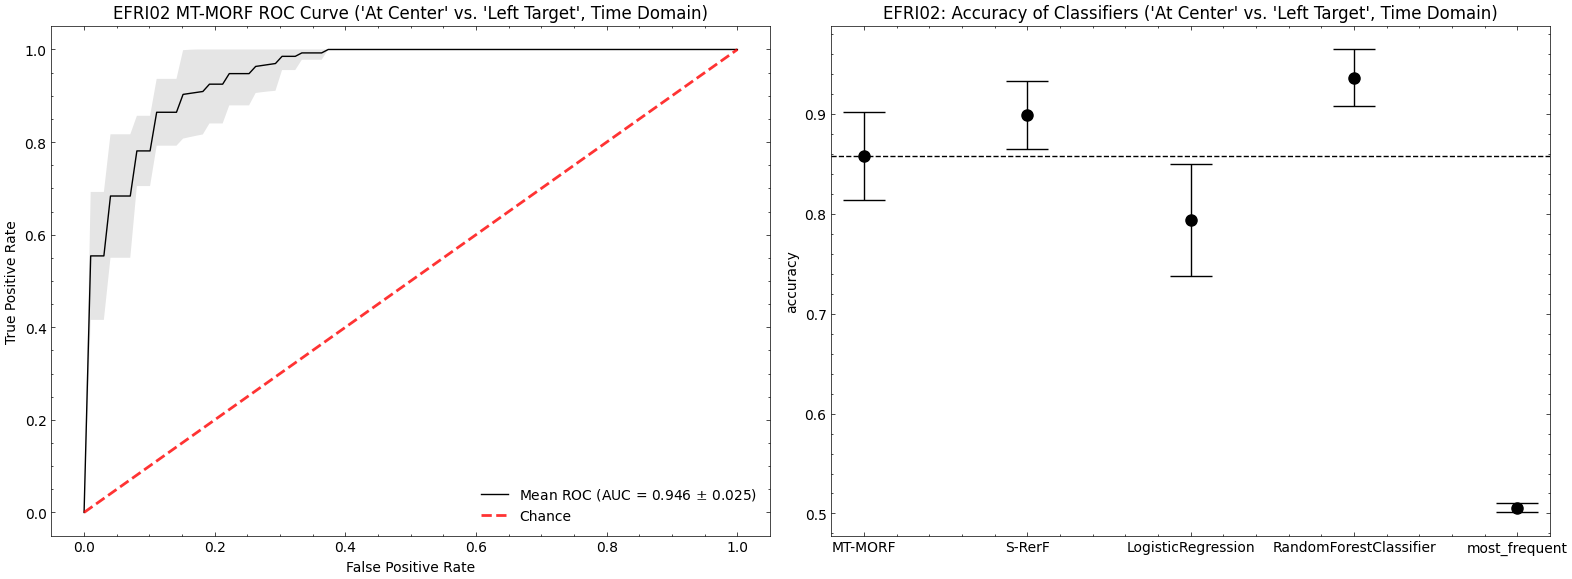

In [10]:
## Plot results
domain = "time"
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs.flatten()

for clf_name, scores in clf_scores.items():
    plot_roc_cv(scores["test_predict_proba"], X, y, scores["test_inds"], 
                label=clf_name, show_chance=False, ax=axs[0])

axs[0].set(xlabel="False Positive Rate", ylabel="True Positive Rate", 
           xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"{subject.upper()} MT-MORF ROC Curve ('At Center' vs. 'Left Target', {domain.capitalize()} Domain)")
axs[0].legend(loc="lower right")

## Plot results
plot_accuracies(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers ('At Center' vs. 'Left Target', {domain.capitalize()} Domain)")
fig.tight_layout()

destination = results_path / subject / "movement_onset_experiment"
plt.savefig(destination / f"movement_onset_{domain}_domain.png")
plt.show();

### Freq domain
- `TODO`: For loop for each patient

In [11]:
nfreqs = 10
lfreq, hfreq = (70, 200)
freqs = np.logspace(*np.log10([lfreq, hfreq]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency

before_power = tfr_morlet(before, freqs=freqs, n_cycles=n_cycles, average=False,
                          return_itc=False, decim=3, n_jobs=1).data
after_power = tfr_morlet(after, freqs=freqs, n_cycles=n_cycles, average=False,
                         return_itc=False, decim=3, n_jobs=1).data

Not setting metadata
Not setting metadata


In [12]:
ntrials, nchs, nfreqs, nsteps = before_power.shape

X = np.vstack([
    before_power.reshape(before_power.shape[0], -1),  # class 0
    after_power.reshape(after_power.shape[0], -1)     # class 1
])
y = np.concatenate([
    np.zeros(len(before_power)),
    np.ones(len(after_power))
])

assert X.shape[0] == y.shape[0], "X and y do not have the same number of epochs"

print(X.shape, y.shape)

(267, 106880) (267,)


In [13]:
## Cross validate for all models
clf_scores = dict()
clfs = initialize_classifiers(nchs*nfreqs, nsteps, n_jobs=-1, random_state=seed)

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(clf, X, y, cv=cv, metrics=metrics, n_jobs=None,
                                  return_train_score=True, return_estimator=True)

100%|██████████| 5/5 [19:19<00:00, 231.96s/it]


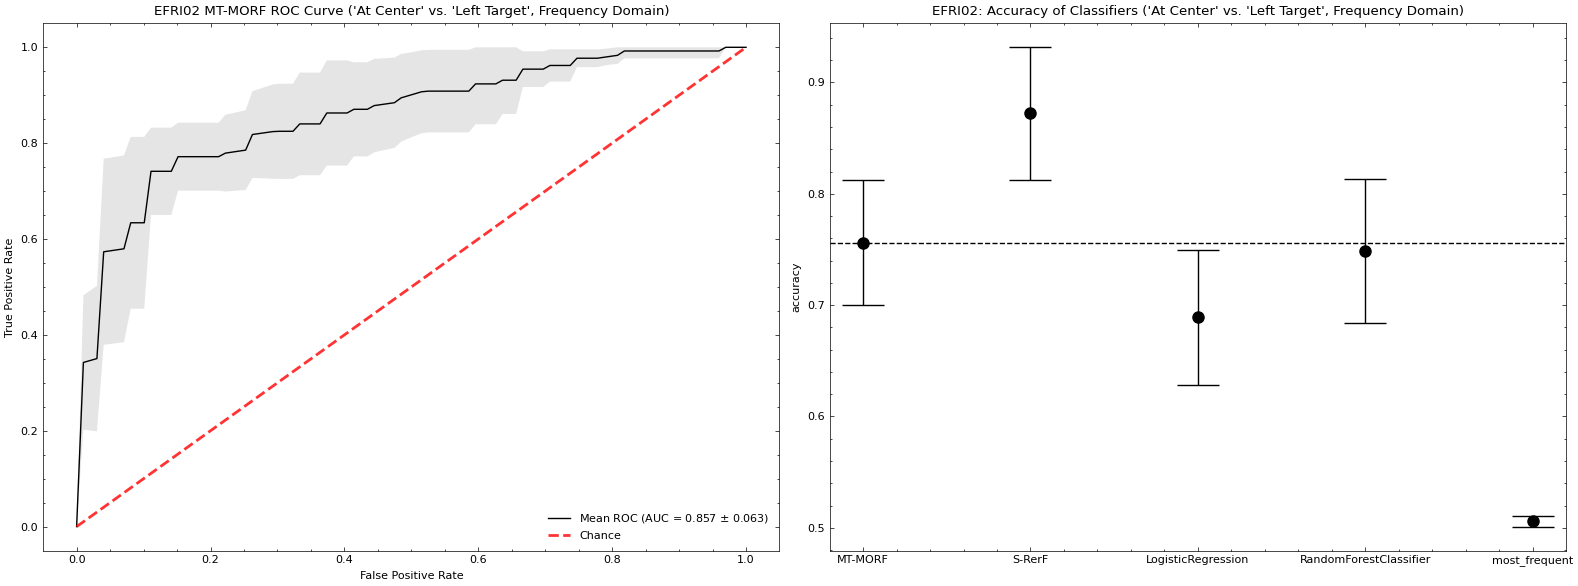

In [19]:
## Plot roc curves
domain = "frequency"
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs.flatten()

plot_roc_cv(stratified_kf_scores["test_predict_proba"], X, y, 
            stratified_kf_scores["test_inds"], ax=axs[0])

for clf_name, scores in clf_scores.items():
    plot_roc_cv(scores["test_predict_proba"], X, y, scores["test_inds"],
                label=clf_name, show_chance=False, ax=axs[0])

axs[0].set(xlabel="False Positive Rate", ylabel="True Positive Rate", 
           xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"{subject.upper()} MT-MORF ROC Curve ('At Center' vs. 'Left Target', {domain.capitalize()} Domain)")
axs[0].legend(loc="lower right")

## Plot Accuracies
plot_accuracies(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers ('At Center' vs. 'Left Target', {domain.capitalize()} Domain)")
fig.tight_layout()

destination = results_path / subject / "movement_onset_experiment"
plt.savefig(destination / f"movement_onset_{domain}_domain.png")
plt.show();